# Trying Out the Ollama for Chat

in this notebook we'll test out langgraph and ollama implementation for a chat. We'll run in on the MacBook. We can extend it with Gradio later

### Setting up the graph nodes. 

We will implement summarisation after certain amount of words rather than number of messages.

In [1]:
from dotenv import load_dotenv, find_dotenv
from langgraph.graph import END
from langchain_core.messages.utils import get_buffer_string
from typing_extensions import Literal, List
from langchain_community.tools.tavily_search import TavilySearchResults
from datetime import date
_ = load_dotenv(find_dotenv()) # read local .env file

from langgraph.graph import MessagesState
class State(MessagesState):
    max_tokens: int = 1024
    summary: str
    search_context: str = "No additional context."
    search_prompt: str = ""
    current_question: str = ""
    reflection: str = ""
    search_attempts: int = 0


In [2]:
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage, AIMessage

# Define the logic to call the model
def call_model(state: State):
    
    # Get summary if it exists
    summary = state.get("summary", "")
    search_context = state.get("search_context", "No context available")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        summary_system_message = f"{system}\n\nSummary of conversation earlier: {summary}.\n\nContext: {search_context}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=summary_system_message)] + state["messages"]
    
    else:
        context_system_message = f"{system}\n\nContext: {search_context}"
        messages = [SystemMessage(content=context_system_message)] + state["messages"]

    result = llm.invoke(messages)
    return {"messages": result, "search_prompt": ""}

In [3]:
def summarise(state: State):
    summary = state.get("summary", "")
    prompt = ""
    if summary == "":
        prompt = f"""
You are to generate a summary of this conversation. Please keep it concise but do not miss out any important
details. Below is the conversation thus far:

{state["messages"]}
"""
    else:
        prompt = f"""


Please summarise the conversation thus far. There is already a summary of previous conversation below. 
Take only the key parts of it and extend them with the current conversation into a new summary.

Existing summary:
{summary}

+++++++++++++++++++++++++++++++++

Our conversation:
{state["messages"]}
"""
    result = llm.invoke(prompt)
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": result.content, "messages": delete_messages}
    

In [4]:
def get_input(state: State):
    
    """ We will use this to inject input through interrupt """
    pass

In [5]:
def should_summarise(state: State) -> Literal["summarise", "get_input", "prompt_writer", "call_model"]:
    reflection = state.get('reflection', '')
    current_search_tally = int(state.get('search_attempts', 0))

    if reflection == 'research':
        print('SEARCH attempts', current_search_tally)
        if current_search_tally < max_search_attempts:
            return "prompt_writer"
        else:
            print("calling model, search attempts exceeded")
            return "call_model"
    
    flattened = get_buffer_string(state["messages"])
    words = flattened.split(" ")
    max_tokens = state.get("max_tokens", 1024)
    if len(words) > max_tokens:
        return "summarise"
    else:
        return "get_input"

def route(state: State) -> Literal["call_model", "prompt_writer", END]:
    
    """ We will use this conditional edge to make a decision on the next action: call the model, do a search or end """
    
    last_message = state["messages"][-1]
    messages = state["messages"]
    if last_message.content == "END":
        return END
    else:
        system = f"""
You are a helpful LLM chatbot with a vast knowledge of topics up to {model_cutoff_date}. 
Your task is to decide how to handle an input by your Human friend based on its relevance to recent events or historical knowledge.

Today is {date.today()}.

**Instructions**:
1. If the question or conversation explicitly or implicitly references events, dates, or topics likely occurring or changing **after {model_cutoff_date}**, 
return "prompt_writer".
Examples of such questions:
- "What's the latest on AI breakthroughs?"
- "Who won the 2024 Olympics?"
- "What time is it now?"
- "Did <something> happen recently"
- Any questions that reference recent events, like qustions including the words "recently", "this year", "latest", etc.

2. If the question concerns **historical topics confidently within your training data**, return "call_model". If there is no infered question in the
human input below, also return "call_model".
Examples:
- "Who was the first president of the USA?"
- "Explain the theory of relativity."

**Remember**
Only return a single word. Either: "call_model" or "prompt_writer". Nothing else.
"""
        
        human = f"""


**Human Input**:
{last_message.content}
"""
        result = llm.invoke([SystemMessage(system), HumanMessage(human)])
        print("ROUTING TO", result.content)
        if result.content == 'call_model' or result.content == 'prompt_writer':
            return result.content
        return 'call_model' # in any other case falling back..

def prompt_writer(state: State):

    """ This will be used to write a proper search prompt based on the question posed """
    
    question = state["current_question"]
    prompt = f"""Consider the question below. Please provide an excellently formatted prompt for a web search. 
    The results of the search will be used as an additional context to answer the question. Return the prompt
    as a string, without further explanations or preamble.
    
    Here is the question:

    {question}
    """

    result = llm.invoke(prompt)
    return {"search_prompt": result.content}

def search(state: State):

    """ This will be used to perform a web search via Tavily """
    print("SEARCH")
    search_prompt = state.get("search_prompt", "")
    if search_prompt:
        tavily_search = TavilySearchResults(max_results=3)
        searches = tavily_search.invoke(state["search_prompt"])
    
        #format them
        docs = "\n\n----------\n\n".join([f'<Document href="{doc["url"]}">\n{doc["content"]}\n</Document>' for doc in searches])
        print("DOCS", docs, type(docs))
        return {"search_context": docs}
    else:
        return {"search_context": ""}

def reflect_on_answer(state: State):
    
    """ Reflect on the answer and decide whether to resort to search """
    question = state.get("current_question", "")
    context = state.get("search_context", "No context available.")
    last_message = state["messages"][-1]
    print('instance', isinstance(last_message, AIMessage))
    if question and isinstance(last_message, AIMessage):
        system = f"""
You are to analyse the below AI answer and reflect if it answers the human's question. Take into consideration if any context is provided.

Context:

{context}

Here is the question:

{question}.

When reflecting think whether the answer is thorough and addresses all the points raised by the human. Think if the answer exhibits a level of uncertainty,
or if you would suggest a further web search to provide additional context to improve the answer.

Here is the AI answer

{last_message.content}
"""
        human = """
Provide your verdict on the quality of answer by returning the string 'approved' if the answer addresses the query raised with good
degree of certainty. If you deem the answer needs improvemend report 'research'. 

If the human asked no further questions just report 'approved' to continue the conversation.

Only answer with 'approved' or 'research'. Nothing else.
"""
        
        # Generate a query
        result = llm.invoke(
            [SystemMessage(system),
            HumanMessage(human)]
        )   
        print('My reflection is: ', result.content)
        # Lets clean last answer if reflection is research
        search_attempts = int(state.get('search_attempts', 0))
        if result.content == "research" and search_attempts < max_search_attempts:
            return {"reflection": result.content, "messages": [RemoveMessage(id=last_message.id)], "search_attempts": search_attempts + 1}
        else:
            return {"reflection": "approved", "search_attempts": 0}
    
    # fallback    
    return {"reflection": "approved", "search_attempts": 0}
    

In [6]:
route({"messages":[HumanMessage("Did Snoop release new album recently?")]})
# prompt_writer({"messages":[HumanMessage("What was the most recent discovery by the particle collider?")]})

NameError: name 'model_cutoff_date' is not defined

### Let's define the LLM here

we'll use the ChatOllama to implement inference over Ollama. This will abstract the platform for inference. It will work with any nVidia, Apple Silicon or CPU, as Ollama will do the heavy lifting. We only need to have it as a docker running as a service 'ollama'

We also define few constants that are used by the graph.

In [6]:
from langchain_ollama import ChatOllama

llm = ChatOllama(
    model="llama3.1:8b-instruct-fp16",
    temperature=0.12,
    base_url="ollama"
)
model_cutoff_date = "December, 2023"
system = f"""You are a helpful chatbot. You carry out polite conversations with operators and try to help to the best of your knowledge.
If additional context is provided, you it to complement your knowledge on the subject.
"""
max_search_attempts = 2

###  The Graph

here we'll define the graph

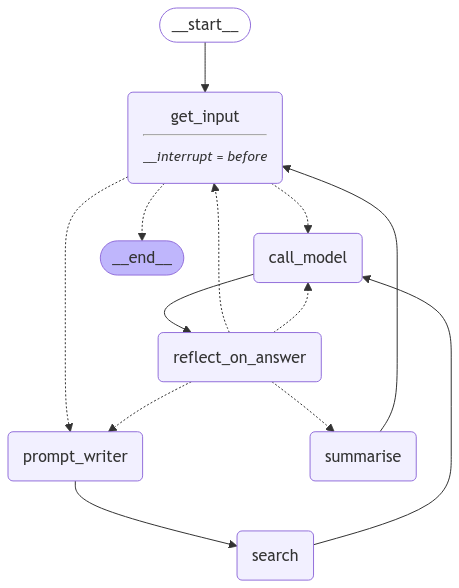

In [7]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from IPython.display import Image, display

memory = MemorySaver()
builder = StateGraph(State)

builder.add_node("get_input", get_input)
builder.add_node("prompt_writer", prompt_writer)
builder.add_node("search", search)
builder.add_node("call_model", call_model)
builder.add_node("summarise", summarise)
builder.add_node("reflect_on_answer", reflect_on_answer)
builder.add_edge(START, "get_input")
builder.add_conditional_edges("get_input", route)
builder.add_edge("prompt_writer", "search")
builder.add_edge("search", "call_model")
builder.add_edge("call_model", "reflect_on_answer")
builder.add_conditional_edges("reflect_on_answer", should_summarise)
builder.add_edge("summarise", "get_input")

memory = MemorySaver()
graph = builder.compile(checkpointer=memory, interrupt_before=["get_input"])
display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
config = {"configurable": {"thread_id": "3"}}

for event in graph.stream({"messages": "", "max_tokens": 1024}, config=config, stream_mode="values"):
    event['messages'][-1].pretty_print()
counter = 0
next_step = graph.get_state(config=config).next
while next_step != ():
    inp = input("Provide your input here. 'END' to end session: ")
    graph.update_state(
        config,
        {"messages": [HumanMessage(content=inp)], "search_attempts": 0, "reflection": "", "current_question": inp, "search_context": ""},
        as_node="get_input"
    )
    for event in graph.stream(None, config, stream_mode="values"):
        event['messages'][-1].pretty_print()
    next_step = graph.get_state(config=config).next
    counter += 1


================================ Human Message =================================




Provide your input here. 'END' to end session:  Did David Lynch die recently?


ROUTING TO call_model
================================ Human Message =================================

Did David Lynch die recently?
================================== Ai Message ==================================

I'm not aware of any recent news about David Lynch passing away. However, I can suggest some possible sources where you might be able to find information about him.

David Lynch is an American filmmaker, artist, and musician who is still active in the entertainment industry. He's best known for his surrealist films like "Eraserhead," "Blue Velvet," and "Twin Peaks." 

If you're concerned about a specific report or rumor you've heard, I recommend checking reputable news sources such as The New York Times, Variety, or Entertainment Weekly to see if they have any information on the matter.

Would you like me to look up some of his recent projects or interviews?
instance True
My reflection is:  approved
================================== Ai Message =============================

Provide your input here. 'END' to end session:  Is he still alive in 2025?


ROUTING TO prompt_writer
================================ Human Message =================================

Is he still alive in 2025?
================================ Human Message =================================

Is he still alive in 2025?
SEARCH
DOCS <Document href="https://www.uscis.gov/sites/default/files/document/forms/i-129.pdf">
Jan 17, 2025 · Change the status and extend the stay of each beneficiary because the beneficiary(ies) is/are now in the United States in another status (see
</Document>

----------

<Document href="https://www.americanimmigrationcouncil.org/research/temporary-protected-status-overview">
Jan 22, 2025 · This fact sheet provides an overview of how Temporary Protected Status designations are made, what benefits TPS confers, and how TPS
</Document>

----------

<Document href="https://www.reddit.com/r/delta/comments/18u8gwh/i_am_so_bummed_about_the_change_in_status_for_2025/">
Dec 30, 2023 · The Delta Platinum and Reserve cards give you $2500 MQDs on Februa

Provide your input here. 'END' to end session:  David Lynch current status.


ROUTING TO call_model
================================ Human Message =================================

David Lynch current status.
================================== Ai Message ==================================

I've searched for the latest information on David Lynch's current status, but I'm a large language model, my training data only goes up to 2022. However, I can suggest some possible sources where you might be able to find more recent updates.

As of 2022, David Lynch was still active in the entertainment industry and had been working on various projects, including his popular podcast "The Art of Conversation" and his music releases with his band, The Blue Boy.

You can try checking reputable online sources such as:

* David Lynch's official website: This might have updates on his current projects or activities.
* Social media platforms: You can check his official social media accounts to see if he has posted any recent updates.
* Entertainment news websites: Websites like Var

Provide your input here. 'END' to end session:  Why is a LLM not able to evaluate when to use a search tool to find more recent information?


ROUTING TO prompt_writer
================================ Human Message =================================

Why is a LLM not able to evaluate when to use a search tool to find more recent information?
================================ Human Message =================================

Why is a LLM not able to evaluate when to use a search tool to find more recent information?
SEARCH
DOCS <Document href="https://arxiv.org/abs/2412.12472">
Although large language models (LLMs) store vast amount of knowledge in their parameters, they still have limitations in the memorization and utilization of certain knowledge, leading to undesired behaviors such as generating untruthful and inaccurate responses. This highlights the critical need to understand the knowledge boundary of LLMs, a concept that remains inadequately defined in
</Document>

----------

<Document href="https://aclanthology.org/2024.lrec-main.1465/">
This research introduces the Think-Solve-Verify (TSV) framework, an innovative stra

Provide your input here. 'END' to end session:  what is the oldest still functioning library in the world?


ROUTING TO call_model
================================ Human Message =================================

what is the oldest still functioning library in the world?
================================== Ai Message ==================================

The oldest still-functioning library in the world is the Library of Congress's predecessor, the Bodleian Library at Oxford University, which was founded in 1602.

However, if you're looking for a library that has been continuously operating since ancient times, I'd like to suggest the following contenders:

1. **Library of Ashurbanipal** (circa 668 BCE): This ancient Assyrian library is believed to be one of the oldest known libraries in the world. Although it was destroyed by the Babylonians in 612 BCE, its remains were rediscovered in the 19th century.
2. **Library of Alexandria** (circa 300 BCE): While not entirely intact, the Library of Alexandria's legacy lives on through various fragments and accounts from ancient sources. It's considered 

Provide your input here. 'END' to end session:  END


================================ Human Message =================================

END
